# Análisis de Modelos de Estado para el Metano

## 1. Introducción

Se proporciona una serie de tablas con valores de presión ($P$) y volumen específico ($V$) del metano a distintas temperaturas constantes ($T$). Cada tabla contiene puntos discretos. En el fichero Excel adjunto se encuentran los valores de presión en MPa y volumen en m³/kg a diferentes temperaturas.

Uno de los objetivos es obtener el valor de $V$ dadas unas condiciones donde $P$ y $V$ no son constantes. Para ello, se desea utilizar dos ecuaciones de estado de los gases reales.

## 2. Ecuaciones de Estado de los Gases Reales

### 2.1 Ecuación de Peng-Robinson

La ecuación de Peng-Robinson es una ecuación de estado cúbica, ampliamente utilizada en termodinámica de fluidos para modelar el comportamiento de gases y líquidos. Su forma general es:

$$
P = \frac{RT}{V - b} - \frac{a}{V^2 + 2bV - b^2}
$$

Donde la constante $a$ se calcula como:

$$
a = 0.4572 \cdot \frac{R^2 T_c^2}{P_c} \cdot \alpha(T_r, \omega)
$$

$$
\alpha(T_r, \omega) = 0.4572 \cdot \frac{R^2 T_c^2}{P_c} \cdot \left[1 + k(1 - \sqrt{T/T_c})\right]
$$

$$
k = 0.37 + 1.5\omega - 0.26\omega^2
$$

$$
b = 0.077 \cdot \frac{RT_c}{P_c}
$$

Para el metano, los valores críticos y el factor acéntrico son:

- **Temperatura crítica:** $T_c = 190.56$ K
- **Presión crítica:** $P_c = 4.59$ MPa
- **Volumen crítico:** $V_c = 98.6$ cm³/mol
- **Factor acéntrico:** $\omega = 0.011$

### 2.2 Ecuación del Virial

La ecuación del virial es una expansión en series de la ecuación de estado de un gas real en términos del volumen molar:

$$
Z = \frac{PV}{RT} = 1 + \frac{B(T)}{V} + \frac{C(T)}{V^2} + \dots
$$

Donde $B(T)$ y $C(T)$ son los coeficientes de Virial. El primero se puede aproximar mediante:

$$
B(T) = -0.199 + 0.20 \cdot \exp\left(\frac{-1131}{T^2}\right)
$$

El coeficiente $C(T)$ es muy complejo de obtener experimentalmente.

## 3. Problemas a Resolver

### 3.1 Interpolación y regresión

- Realizar gráficas de interpolación polinomial y regresión de los puntos $PV$ que mejor se ajusten al caso.
- Identificar la mejor curva para resolver el problema.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, make_interp_spline
from scipy.optimize import curve_fit

#   Leer el archivo con los datos
df = pd.read_excel('Caso_1.xlsx')
df.head()

# Observando la estructura, cada bloque de datos (T=200, 250, 300, 350 K) ocupa
# tres columnas consecutivas: P, V, (NaN). Repetido 4 veces.
# Filas: 0 y 1 son encabezados. Los datos empiezan en la fila 2.

,Tabla de datos a T = 200 K,Unnamed: 1,Unnamed: 2,Tabla de datos a T = 250 K,Unnamed: 4,Unnamed: 5,Tabla de datos a T = 300 K,Unnamed: 7,Unnamed: 8,Tabla de datos a T = 350 K,Unnamed: 10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg),NaN,P (MPa),V (m³/kg)
2,0.1,25.0,NaN,0.1,30.0,NaN,0.1,35.0,NaN,0.1,40.0
3,0.2,12.5,NaN,0.2,15.2,NaN,0.2,18.0,NaN,0.2,22.0
4,0.3,8.3,NaN,0.3,10.2,NaN,0.3,12.5,NaN,0.3,15.5


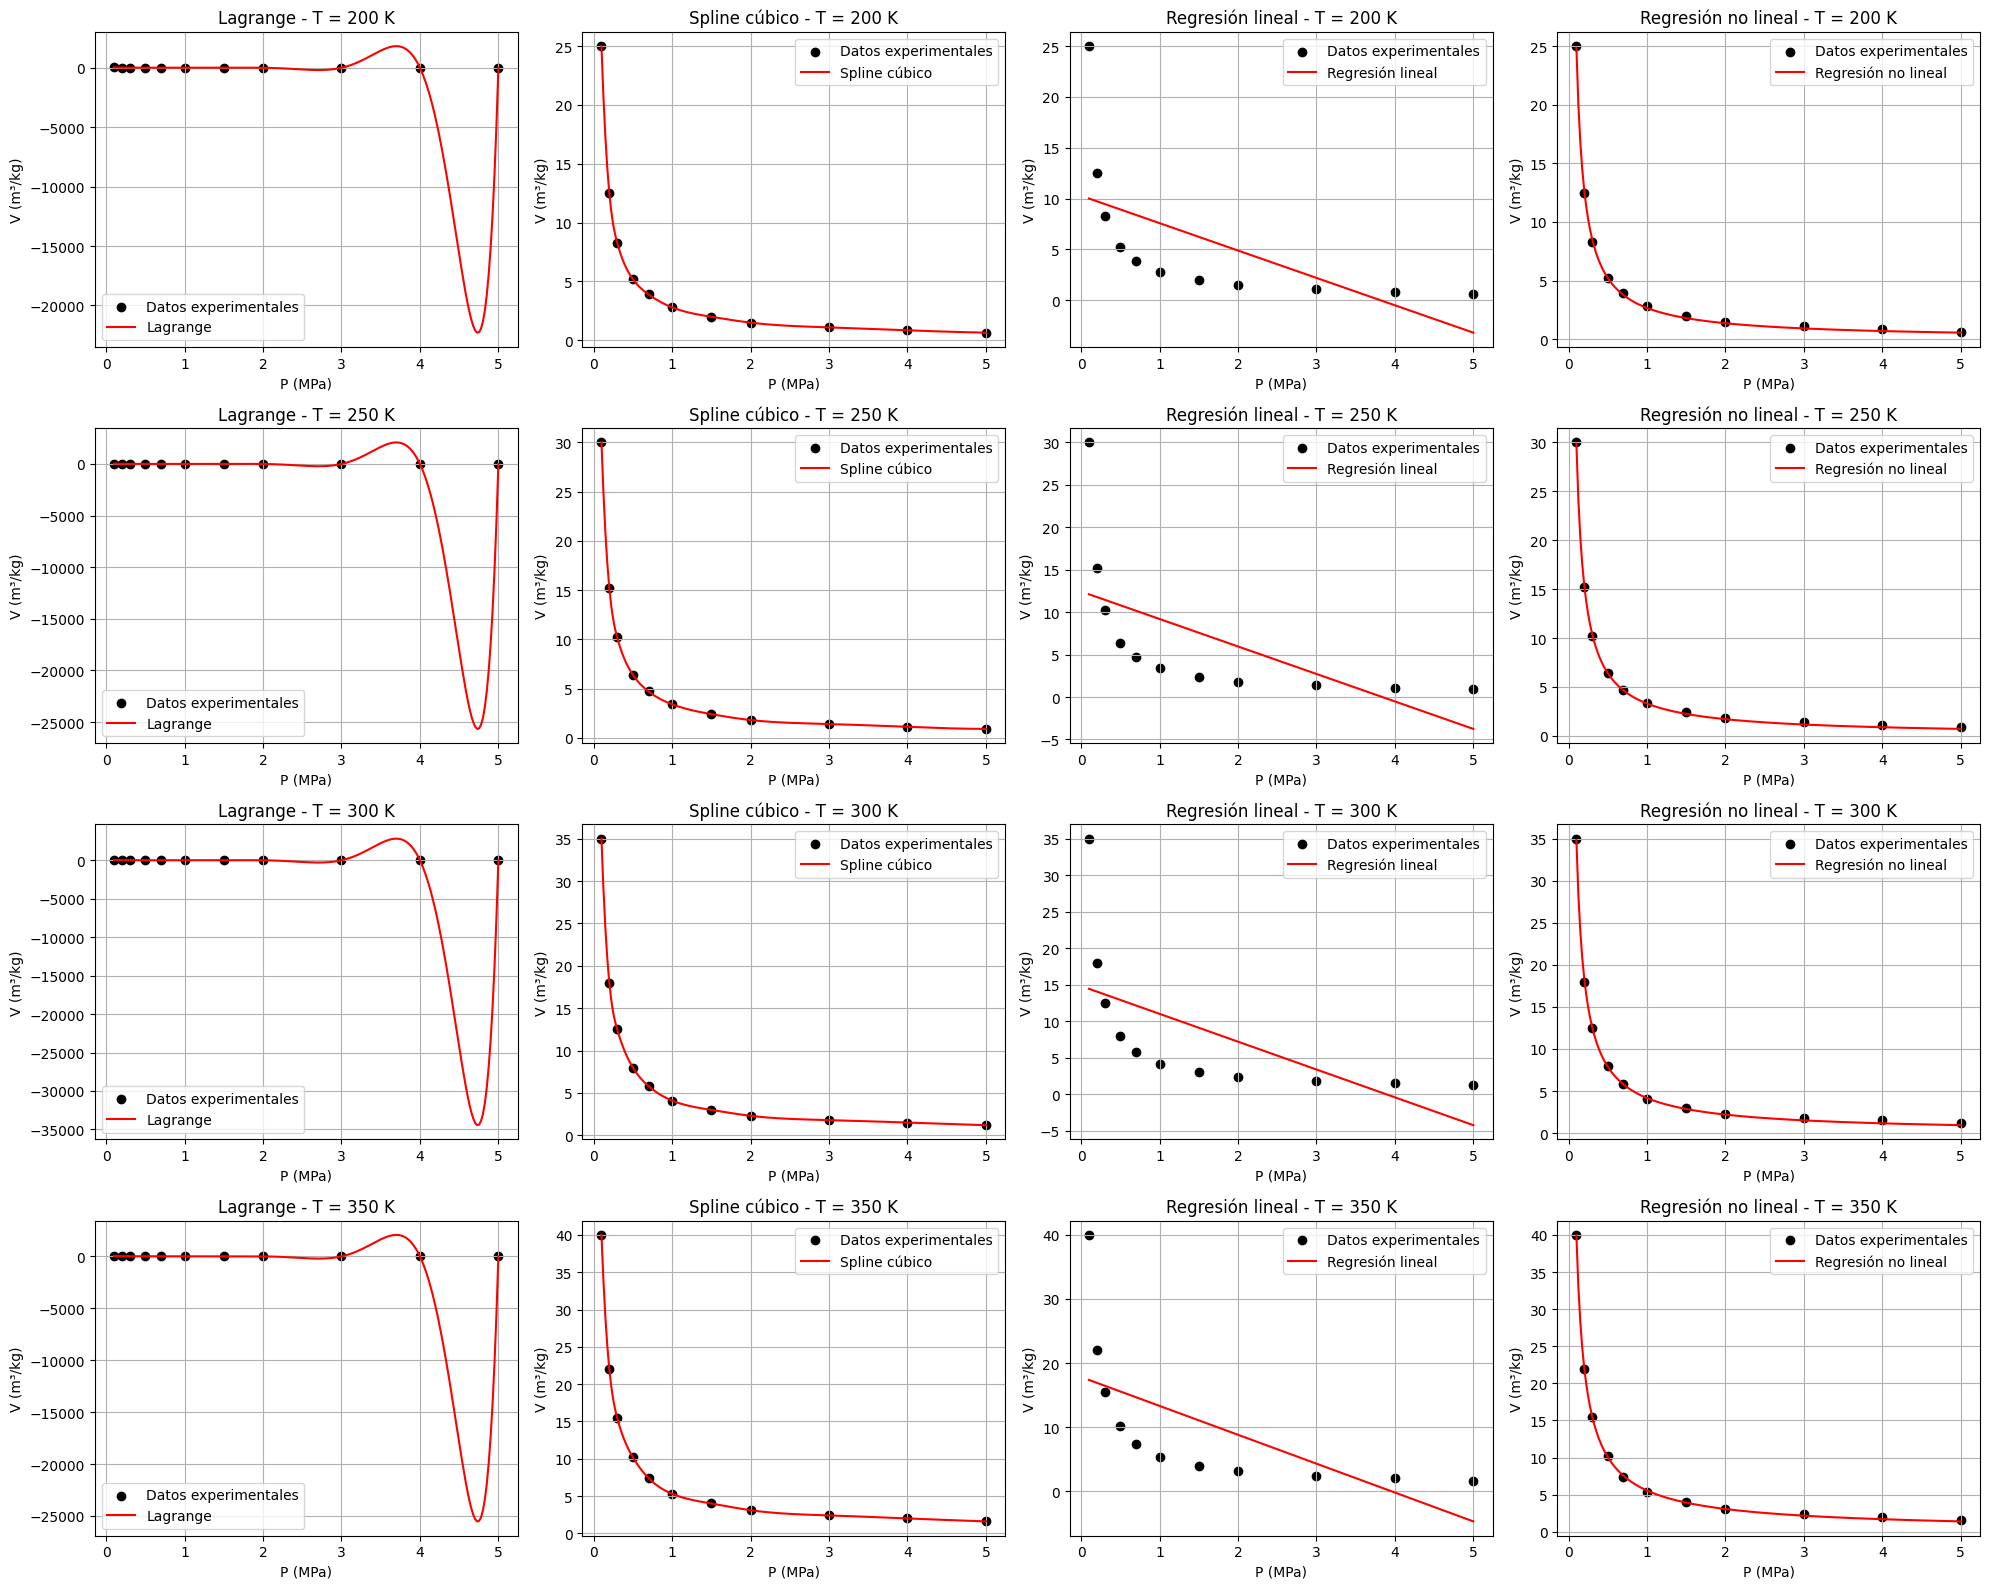

In [8]:
# Definir temperaturas y bloques de columnas (P, V) para cada isoterma.
temperatures = [200, 250, 300, 350]
column_blocks = [(0, 1), (3, 4), (6, 7), (9, 10)]

tidy_data = []
for T, (colP, colV) in zip(temperatures, column_blocks):
    for i in range(2, df.shape[0]):  # Suponemos que los datos comienzan en la fila 2.
        p_val = df.iloc[i, colP]
        v_val = df.iloc[i, colV]
        if pd.notna(p_val) and pd.notna(v_val):
            tidy_data.append({
                "T (K)": T,
                "P (MPa)": float(p_val),
                "V (m³/kg)": float(v_val)
            })

tidy_df = pd.DataFrame(tidy_data)
tidy_df.sort_values(by=["T (K)", "P (MPa)"], inplace=True)
tidy_df.reset_index(drop=True, inplace=True)

# 2. DEFINICIÓN DEL MODELO PARA REGRESIÓN NO LINEAL
def power_law(P, a, b):
    """Modelo de ley de potencia: V = a * P^b"""
    return a * (P ** b)

# 3. DEFINICIÓN DE LOS MÉTODOS A USAR
methods = ["Lagrange", "Spline cúbico", "Regresión lineal", "Regresión no lineal"]

# 4. CONFIGURACIÓN DE LA FIGURA: filas = temperaturas, columnas = métodos
n_rows = len(temperatures)
n_cols = len(methods)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16), squeeze=False)

# Bucle por cada temperatura (fila) y por cada método (columna)
for i, T_val in enumerate(temperatures):
    # Extraer datos de la isoterma T = T_val
    subset = tidy_df[tidy_df["T (K)"] == T_val]
    P_vals = subset["P (MPa)"].values
    V_vals = subset["V (m³/kg)"].values
    # Asegurarse de que estén ordenados según P
    sort_idx = np.argsort(P_vals)
    P_vals = P_vals[sort_idx]
    V_vals = V_vals[sort_idx]
    
    # Definir un grid fino para evaluar las curvas
    P_fine = np.linspace(P_vals.min(), P_vals.max(), 200)
    
    for j, method in enumerate(methods):
        ax = axes[i, j]
        # Graficar los datos experimentales
        ax.scatter(P_vals, V_vals, color="black", label="Datos experimentales")
        
        # Calcular la curva según el método seleccionado:
        if method == "Lagrange":
            try:
                poly_lagrange = lagrange(P_vals, V_vals)
                V_curve = poly_lagrange(P_fine)
            except Exception as e:
                V_curve = None
                print(f"Error en Lagrange para T={T_val}: {e}")
                
        elif method == "Spline cúbico":
            try:
                spline = make_interp_spline(P_vals, V_vals, k=3)
                V_curve = spline(P_fine)
            except Exception as e:
                V_curve = None
                print(f"Error en Spline cúbico para T={T_val}: {e}")
                
        elif method == "Regresión lineal":
            coeffs_lin = np.polyfit(P_vals, V_vals, 1)
            poly_lin = np.poly1d(coeffs_lin)
            V_curve = poly_lin(P_fine)
            
        elif method == "Regresión no lineal":
            try:
                # Usamos como conjetura inicial: a0 = V_vals[0]*P_vals[0] y b0 = -1 (se espera comportamiento similar a V ~ 1/P)
                p0 = [V_vals[0] * P_vals[0], -1]
                popt, _ = curve_fit(power_law, P_vals, V_vals, p0=p0)
                V_curve = power_law(P_fine, *popt)
            except Exception as e:
                V_curve = None
                print(f"Error en Regresión no lineal para T={T_val}: {e}")
        else:
            V_curve = None
        
        # Graficar la curva ajustada, si se pudo calcular
        if V_curve is not None:
            ax.plot(P_fine, V_curve, color="red", label=method)
        
        # Configuración del subplot
        ax.set_title(f"{method} - T = {T_val} K")
        ax.set_xlabel("P (MPa)")
        ax.set_ylabel("V (m³/kg)")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

### 3.2 Interpolación de Hermite

- Representar la función $V = f(T)$ mediante interpolación de Hermite.
- Considerar que la primera derivada $dV/dT = 0.019$ m³/kg·K a una temperatura $T = 300$ K y un volumen específico de $4.1$ m³/kg.

#### Interpolación de Hermite para $V = f(T)$

A continuación se presenta un ejemplo de cómo representar la función:

$$
V = f(T)
$$

mediante interpolación de Hermite, incorporando la condición de derivada:

$$
\left. \frac{dV}{dT} \right|_{T=300\,\text{K}} = 0.019 \, \text{m}^3/\text{kg}\cdot\text{K}
$$

y el dato:

$$
V(300\,\text{K}) = 4.1 \, \text{m}^3/\text{kg}
$$

---

Para construir la interpolación de Hermite necesitamos, además de la información en $T = 300\,\text{K}$, otros nodos para $T$ y $V$.  
Por ejemplo, podemos usar los valores correspondientes a $P = 1.0\,\text{MPa}$ de una tabla de datos:

- $T = 200\,\text{K}$, $V = 2.80 \, \text{m}^3/\text{kg}$
- $T = 250\,\text{K}$, $V = 3.40 \, \text{m}^3/\text{kg}$
- $T = 300\,\text{K}$, $V = 4.10 \, \text{m}^3/\text{kg}$  ⟶ condición especial: $\left. \frac{dV}{dT} \right|_{T=300} = 0.019$
- $T = 350\,\text{K}$, $V = 5.30 \, \text{m}^3/\text{kg}$

---

##### Estimación de derivadas

Dado que para la interpolación de Hermite se requieren las derivadas en todos los nodos, podemos estimarlas mediante **diferencias finitas**:

- En $T = 200\,\text{K}$:

$$
\left. \frac{dV}{dT} \right|_{200} \approx \frac{3.40 - 2.80}{250 - 200} = \frac{0.60}{50} = 0.012 \, \text{m}^3/\text{kg}\cdot\text{K}
$$

- En $T = 250\,\text{K}$ (diferencia central aproximada):

$$
\left. \frac{dV}{dT} \right|_{250} \approx \frac{4.10 - 2.80}{300 - 200} = \frac{1.30}{100} = 0.013 \, \text{m}^3/\text{kg}\cdot\text{K}
$$

- En $T = 300\,\text{K}$ (valor dado):

$$
\left. \frac{dV}{dT} \right|_{300} = 0.019 \, \text{m}^3/\text{kg}\cdot\text{K}
$$

- En $T = 350\,\text{K}$:

$$
\left. \frac{dV}{dT} \right|_{350} \approx \frac{5.30 - 4.10}{350 - 300} = \frac{1.20}{50} = 0.024 \, \text{m}^3/\text{kg}\cdot\text{K}
$$

---

##### Interpolación con SciPy

Con estos datos podemos utilizar la clase `CubicHermiteSpline` de **SciPy** para generar la interpolación de Hermite que respeta tanto los valores como las derivadas.

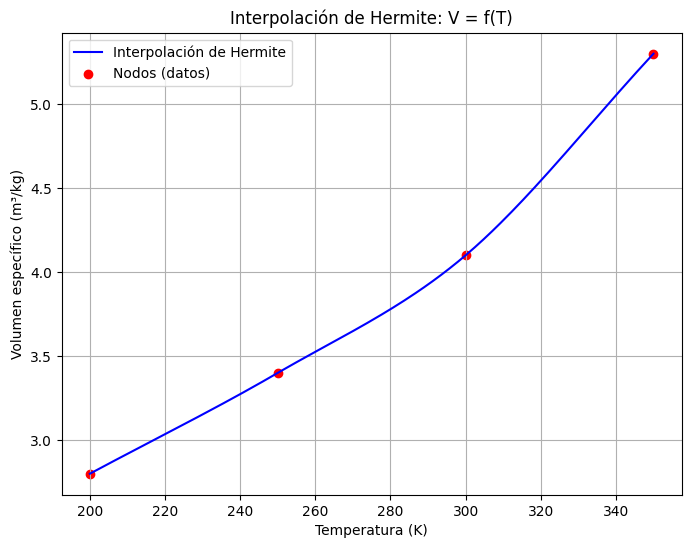

Tabla de nodos utilizados para la interpolación de Hermite:
   T (K)  V (m³/kg)  dV/dT (m³/kg·K)
0  200.0        2.8            0.012
1  250.0        3.4            0.013
2  300.0        4.1            0.019
3  350.0        5.3            0.024

Tabla de valores interpolados (muestra):
        T (K)  V (m³/kg)
0  200.000000   2.800000
1  215.075377   2.977730
2  230.150754   3.154591
3  245.226131   3.338808
4  260.301508   3.529301
5  275.376884   3.717408
6  290.452261   3.933609
7  305.527638   4.210798
8  320.603015   4.558863
9  335.678392   4.941646


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import pandas as pd

# Datos de los nodos (usando datos de P=1.0 MPa como ejemplo)
T_nodes = np.array([200, 250, 300, 350], dtype=float)
V_nodes = np.array([2.80, 3.40, 4.10, 5.30], dtype=float)

# Estimación de derivadas (dV/dT) en cada nodo:
dVdT = np.empty_like(T_nodes)
dVdT[0] = (V_nodes[1] - V_nodes[0]) / (T_nodes[1] - T_nodes[0])  # Aproximadamente 0.012 m³/kg·K
dVdT[1] = (V_nodes[2] - V_nodes[0]) / (T_nodes[2] - T_nodes[0])  # Aproximadamente 0.013 m³/kg·K
dVdT[2] = 0.019  # Dado: en T=300 K, dV/dT = 0.019 m³/kg·K
dVdT[3] = (V_nodes[3] - V_nodes[2]) / (T_nodes[3] - T_nodes[2])  # Aproximadamente 0.024 m³/kg·K

# Creación de la interpolación de Hermite
hermite_interp = CubicHermiteSpline(T_nodes, V_nodes, dVdT)

# Evaluación de la función en un grid fino de temperaturas
T_fine = np.linspace(T_nodes[0], T_nodes[-1], 200)
V_fine = hermite_interp(T_fine)

# Graficar la interpolación
plt.figure(figsize=(8,6))
plt.plot(T_fine, V_fine, label='Interpolación de Hermite', color='blue')
plt.scatter(T_nodes, V_nodes, color='red', label='Nodos (datos)')
plt.xlabel('Temperatura (K)')
plt.ylabel('Volumen específico (m³/kg)')
plt.title('Interpolación de Hermite: V = f(T)')
plt.legend()
plt.grid(True)
plt.show()

# 1. Tabla de nodos (con las derivadas usadas)
tabla_nodos = pd.DataFrame({
    "T (K)": T_nodes,
    "V (m³/kg)": V_nodes,
    "dV/dT (m³/kg·K)": np.round(dVdT, 3)
})
print("Tabla de nodos utilizados para la interpolación de Hermite:")
print(tabla_nodos)

# 2. Tabla de valores interpolados (muestra)
# Se crea una tabla con todos los valores y se muestra una muestra de la misma
tabla_interp = pd.DataFrame({
    "T (K)": T_fine,
    "V (m³/kg)": V_fine
})
# Seleccionamos cada 20ª fila para la muestra
tabla_muestra = tabla_interp.iloc[::20, :].reset_index(drop=True)
print("\nTabla de valores interpolados (muestra):")
print(tabla_muestra)

### 3.3 Validación de la Ecuación de Peng-Robinson

- Analizar si la curva interpolada en la sección **3.1** se ajusta a la ecuación de Peng-Robinson.
- Resolver la ecuación para cada punto $P$ y calcular el error cometido.
- Elaborar un diagrama de flujo explicando el procedimiento para resolver esta cuestión.
- Realizar el análisis únicamente para $T = 250$ K con un error mínimo de $0.001$.

In [14]:
import numpy as np
import sympy as sp
import pandas as pd

# ---------------------------
# Datos del metano a 250 K
# ---------------------------
R_val = 8.314      # J/(mol·K)
Tc = 190.56        # K
Pc = 4.59e6        # Pa
w = 0.011          # Factor acéntrico (adimensional)
T_val = 250        # K
M_metan = 0.01604  # kg/mol

# ---------------------------
# Datos experimentales
# ---------------------------
P_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]  # MPa
V_real = [30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9]  # m³/kg

# Conversión de unidades:
# Convertir presiones de MPa a Pa
P_list_Pa = [P * 1e6 for P in P_list]
# Convertir volúmenes de m³/kg a m³/mol (multiplicando por la masa molecular)
V_real_m3mol = [v * M_metan for v in V_real]

# ---------------------------
# Constantes de Peng-Robinson
# ---------------------------
Tr = T_val / Tc
k = 0.37464 + 1.54226 * w - 0.26992 * w**2
alpha = (1 + k * (1 - np.sqrt(Tr)))**2
a_val = 0.45724 * (R_val**2 * Tc**2 / Pc) * alpha
b_val = 0.07780 * (R_val * Tc / Pc)

# ---------------------------
# Ecuación de Peng-Robinson (simbólica)
# ---------------------------
V = sp.symbols('V')
R, T, a, b, P = sp.symbols('R T a b P')
# La forma usada es:
# f(V) = (R*T)/(V - b) - a/(V**2 + 2*b*V - b**2) - P = 0
fx_expr = (R * T) / (V - b) - a / (V**2 + 2 * b * V - b**2) - P

# ---------------------------
# Método de Newton-Raphson usando sympy
# ---------------------------
def newton_raphson_sympy(fx_expr, R_val, T_val, a_val, b_val, P_val, x0, tol=1e-8, max_iter=100):
    # Sustituir los parámetros en la expresión simbólica
    fx_subs = fx_expr.subs({R: R_val, T: T_val, a: a_val, b: b_val, P: P_val})
    x = sp.symbols('V')
    # Función y derivada en forma numérica (lambdified)
    fx = sp.lambdify(x, fx_subs, 'numpy')
    dfx_expr = sp.diff(fx_subs, x)
    dfx = sp.lambdify(x, dfx_expr, 'numpy')

    itera = 0
    tramo = float('inf')
    x_values = [x0]  # Para guardar las iteraciones

    while tramo > tol and itera < max_iter:
        fx0 = fx(x0)
        dfx0 = dfx(x0)
        if dfx0 == 0:
            break
        x1 = x0 - fx0 / dfx0
        tramo = abs(x1 - x0)
        x0 = x1
        x_values.append(x0)
        itera += 1

    return x1, x_values

# ---------------------------
# Cálculo para cada presión
# ---------------------------
resultados = []
for i, P_val in enumerate(P_list_Pa):
    # Volumen real en m³/mol (a partir de datos experimentales)
    Vreal_m3mol = V_real_m3mol[i]
    # Valor inicial: se toma un valor cercano a b (ligeramente mayor)
    x0 = b_val * 1.05
    raiz, iteraciones = newton_raphson_sympy(fx_expr, R_val, T_val, a_val, b_val, P_val, x0)
    # Convertir el volumen obtenido (m³/mol) a m³/kg dividiendo por la masa molecular
    V_est_m3kg = raiz / M_metan

    resultados.append({
        "Presión (MPa)": P_val / 1e6,
        "Volumen real (m³/kg)": V_real[i],
        "Volumen estimado (m³/kg)": np.round(V_est_m3kg, 3),
        "Iteraciones": len(iteraciones)
    })

# ---------------------------
# Mostrar tabla con resultados
# ---------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados.to_string(index=False))


 Presión (MPa)  Volumen real (m³/kg)  Volumen estimado (m³/kg)  Iteraciones
           0.1                  30.0                     1.291           20
           0.2                  15.2                     0.643           19
           0.3                  10.2                     0.427           18
           0.5                   6.4                     0.254           18
           0.7                   4.7                     0.180           17
           1.0                   3.4                     0.125           17
           1.5                   2.4                     0.081           16
           2.0                   1.8                     0.060           16
           3.0                   1.4                     0.038           15
           4.0                   1.1                     0.027           14
           5.0                   0.9                     0.021           14


### 3.4 Estimación del Coeficiente de Virial

- Utilizando los datos del punto **3.2** y considerando una presión constante de 1 MPa, determinar la temperatura $T$ para la cual el coeficiente de Virial es $6 \times 10^{-4}$ m$^6$/Kg$^2$.
- Calcular el número de iteraciones necesarias para un error de $0.01$, $0.001$ y $10^{-10}$.

#### Deducción de la Temperatura para un Coeficiente de Virial Dado

Se desea determinar el valor de la temperatura (a presión constante de 1 MPa) para la cual el **coeficiente de Virial** es:

$$
B = 6 \times 10^{-4} \; \text{m}^6/\text{kg}^2
$$

utilizando los datos (y la interpolación de Hermite) obtenidos en el apartado 3.2.

---

##### Suposición para la deducción

Se define el coeficiente de Virial, basado en la desviación respecto al comportamiento ideal, mediante:

$$
B = \frac{V_{\text{real}} - V_{\text{ideal}}}{\rho_{\text{ideal}}}
$$

donde, para un gas real a presión $P$, se tiene:

- **Volumen ideal:**

$$
V_{\text{ideal}} = \frac{R_s T}{P}
$$

- **Densidad ideal:**

$$
\rho_{\text{ideal}} = \frac{P}{R_s T}
$$

Por lo tanto, al reemplazar:

$$
B = \left( V_{\text{real}} - \frac{R_s T}{P} \right) \cdot \frac{R_s T}{P}
$$

Despejando $V_{\text{real}}$:

$$
V_{\text{real}} = \frac{R_s T}{P} + \frac{B P}{R_s T}
$$

---

##### Parámetros conocidos

- $P = 1 \times 10^6 \, \text{Pa}$
- $R = 8.314 \, \text{J}/(\text{mol}\cdot\text{K})$
- Para metano: $M = 0.01604 \, \text{kg}/\text{mol}$
- $\Rightarrow R_s = \frac{R}{M} \approx 518.6 \, \text{J}/(\text{kg} \cdot \text{K})$
- $B = 6 \times 10^{-4} \, \text{m}^6/\text{kg}^2$

Entonces:

$$
V_{\text{real}} = \frac{518.6 \cdot T}{10^6} + \frac{6 \times 10^{-4} \cdot 10^6}{518.6 \cdot T}
$$

Simplificando:

$$
V_{\text{real}} = 0.0005186 \, T + \frac{600}{518.6 \, T} \approx 0.0005186 \, T + \frac{1.156}{T}
$$

---

##### Ecuación a resolver

Queremos encontrar $T$ tal que:

$$
f(T) = 0.0005186 \, T + \frac{1.156}{T}
$$

Y usamos la función $f_{\text{interp}}(T)$ obtenida mediante interpolación de Hermite a partir de los datos:

- $T = 200\,\text{K}$, $V = 2.80 \, \text{m}^3/\text{kg}$, $\frac{dV}{dT} \approx 0.012$
- $T = 250\,\text{K}$, $V = 3.40 \, \text{m}^3/\text{kg}$, $\frac{dV}{dT} \approx 0.013$
- $T = 300\,\text{K}$, $V = 4.10 \, \text{m}^3/\text{kg}$, $\frac{dV}{dT} = 0.019$
- $T = 350\,\text{K}$, $V = 5.30 \, \text{m}^3/\text{kg}$, $\frac{dV}{dT} \approx 0.024$

Construimos un interpolador cúbico de Hermite $f_{\text{interp}}(T)$ y definimos la función a encontrar su raíz:

$$
F(T) = f_{\text{interp}}(T) - \left(0.0005186\, T + \frac{1.156}{T}\right) = 0
$$

---

##### Observaciones

- Como los datos se encuentran en el rango $200\,\text{K}$ a $350\,\text{K}$, y el comportamiento buscado es más cercano al ideal, el valor de $T$ que satisface la ecuación probablemente se encontrará por **extrapolación**.
- Se propone utilizar el método de **Newton–Raphson** para encontrar la raíz de $F(T)$.
- Se analiza el **número de iteraciones** necesarias para alcanzar errores de:

  - $10^{-2}$
  - $10^{-3}$
  - $10^{-10}$

---

##### Implementación

A continuación se presenta el código que implementa este procedimiento, utilizando interpolación de Hermite y el método de Newton para encontrar la raíz de $F(T)$.


Tabla de estimación del coeficiente de Virial:
  Tolerancia  T_sol (K)  Iteraciones
1.000000e-02 497.397062            8
1.000000e-03 497.397062            8
1.000000e-10 497.397062            9


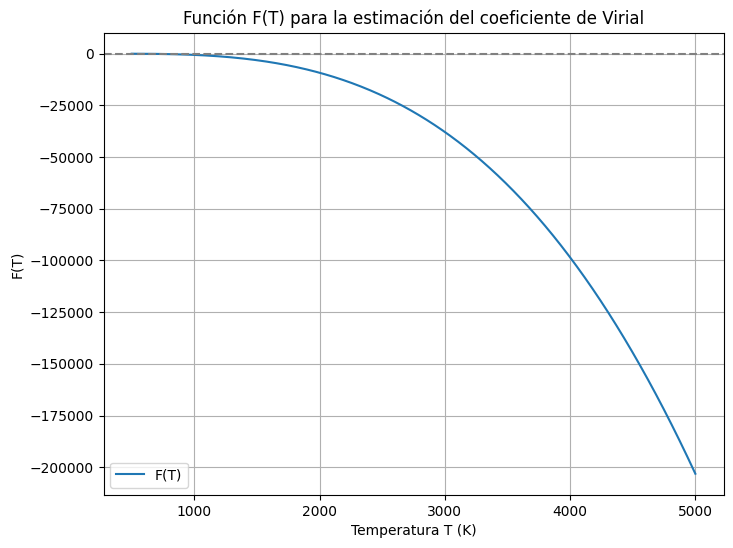

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import pandas as pd

# -------------------------------------
# 1. Construcción de la interpolación de Hermite
# (utilizando los nodos del apartado 3.2)
# -------------------------------------
T_nodes = np.array([200, 250, 300, 350], dtype=float)
V_nodes = np.array([2.80, 3.40, 4.10, 5.30], dtype=float)
# Derivadas estimadas (m³/kg·K)
dVdT = np.array([0.012, 0.013, 0.019, 0.024], dtype=float)

# Construir el interpolador (V = f(T))
f_interp = CubicHermiteSpline(T_nodes, V_nodes, dVdT)

# -------------------------------------
# 2. Definición de la ecuación para la estimación del coeficiente de Virial
# -------------------------------------
# Se asume que el coeficiente de virial se relaciona con la desviación respecto al comportamiento ideal:
# V_ideal = R_s T / P, con R_s = R/M. Para el metano, R=8.314 J/(mol·K) y M=0.01604 kg/mol, 
# de modo que R_s ≈ 518.6 J/(kg·K) (o m³·Pa/(kg·K)) y con P = 1 MPa = 1e6 Pa.
# Además, se impone:
#   V_real = V_ideal + (B P)/(R_s T)
# con B = 6e-4 m^6/kg^2.
# Es decir:
#   f_interp(T) = (518.6 T)/1e6 + (6e-4 * 1e6)/(518.6 T)
#                = 0.0005186 T + 1.156/T.
# Definimos entonces:
def F(T):
    return f_interp(T) - (0.0005186 * T + 1.156 / T)

# Además, la derivada de F(T) se obtiene diferenciando:
# F(T) = f_interp(T) - (0.0005186 T + 1.156/T)
# F'(T) = f_interp'(T) - (0.0005186 - 1.156/T^2)
def F_prime(T):
    return f_interp.derivative()(T) - (0.0005186 - 1.156 / T**2)

# -------------------------------------
# 3. Método de Newton–Raphson para hallar T tal que F(T)=0
# -------------------------------------
def newton_method(F, F_prime, T0, tol):
    T_current = T0
    iterations = 0
    while True:
        f_val = F(T_current)
        fp_val = F_prime(T_current)
        if fp_val == 0:
            break
        T_next = T_current - f_val / fp_val
        iterations += 1
        if abs(T_next - T_current) < tol:
            return T_next, iterations
        T_current = T_next

# Se elegirán tres tolerancias: 1e-2, 1e-3 y 1e-10.
tolerances = [1e-2, 1e-3, 1e-10]
results = []

# Se escoge un valor inicial para T (por ejemplo, 1000 K) dado que la solución se encuentra en extrapolación
T0 = 1000.0

for tol in tolerances:
    T_sol, iters = newton_method(F, F_prime, T0, tol)
    results.append({"Tolerancia": tol, "T_sol (K)": T_sol, "Iteraciones": iters})

# -------------------------------------
# 4. Resultados y Gráfica
# -------------------------------------
df_results = pd.DataFrame(results)
print("Tabla de estimación del coeficiente de Virial:")
print(df_results.to_string(index=False))

# Para visualizar la función F(T) en un rango amplio (por ejemplo, de 500 K a 5000 K)
T_range = np.linspace(500, 5000, 500)
F_vals = F(T_range)

plt.figure(figsize=(8,6))
plt.plot(T_range, F_vals, label="F(T)")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Temperatura T (K)")
plt.ylabel("F(T)")
plt.title("Función F(T) para la estimación del coeficiente de Virial")
plt.legend()
plt.grid(True)
plt.show()

### 3.5 Comparación de Estimaciones del Coeficiente de Virial

- Repetir el cálculo del punto **3.4** para los valores $10^{-4}$ m$^6$/Kg$^2$ y $8.5 \times 10^{-4}$ m$^6$/Kg$^2$ con un error de $0.001$.
- Graficar los resultados obtenidos.

Tabla de resultados para la estimación del coeficiente de Virial:
 B (m^6/kg^2)  T_sol (K)  Iteraciones
      0.00010 497.411262            8
      0.00085 497.389939            8


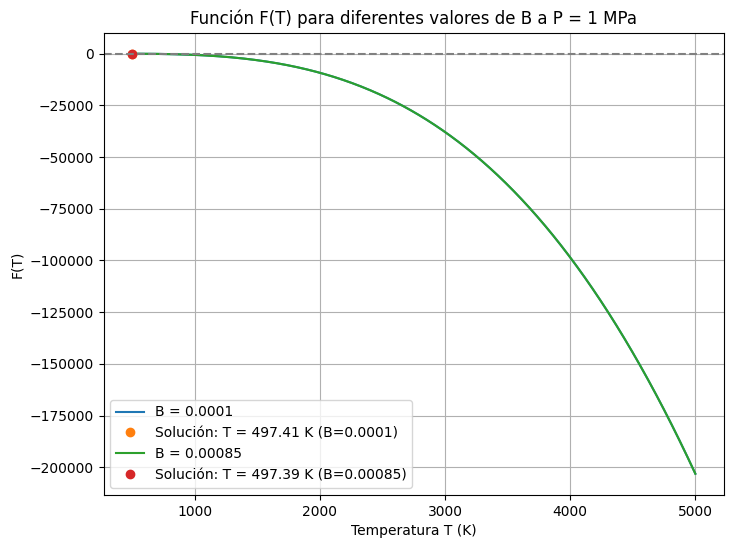

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import pandas as pd

# -------------------------------------
# 1. Interpolación de Hermite (datos de 3.2)
# -------------------------------------
T_nodes = np.array([200, 250, 300, 350], dtype=float)
V_nodes = np.array([2.80, 3.40, 4.10, 5.30], dtype=float)
dVdT = np.array([0.012, 0.013, 0.019, 0.024], dtype=float)

# Interpolador: f_interp(T) da el volumen específico (m³/kg) en función de T.
f_interp = CubicHermiteSpline(T_nodes, V_nodes, dVdT)

# -------------------------------------
# 2. Definición de la función F(T) para el coeficiente de Virial
# -------------------------------------
# Datos:
R_s = 518.6        # m³·Pa/(kg·K) para el metano
P_const = 1e6      # Presión constante de 1 MPa en Pa
ideal_coeff = R_s / P_const  # 518.6/1e6 = 0.0005186

# Para un valor dado de B, la función ideal corregida es:
# V_model(T;B) = ideal_coeff * T + (B*P_const)/(R_s*T)
# Entonces, se define:
def F(T, B):
    C = (B * P_const) / R_s  # C = B*1e6/518.6
    return f_interp(T) - (ideal_coeff * T + C / T)

def F_prime(T, B):
    C = (B * P_const) / R_s
    # La derivada de la parte ideal: d/dT (ideal_coeff*T + C/T) = ideal_coeff - C/T^2.
    return f_interp.derivative()(T) - (ideal_coeff - C / T**2)

# -------------------------------------
# 3. Método de Newton–Raphson (tolerancia = 0.001)
# -------------------------------------
def newton_method(F, F_prime, T0, tol, B):
    T_current = T0
    iterations = 0
    while True:
        f_val = F(T_current, B)
        fp_val = F_prime(T_current, B)
        if fp_val == 0:
            break
        T_next = T_current - f_val / fp_val
        iterations += 1
        if abs(T_next - T_current) < tol:
            return T_next, iterations
        T_current = T_next

# -------------------------------------
# 4. Cálculo para cada valor de B
# -------------------------------------
B_values = [1e-4, 8.5e-4]  # m^6/kg^2
tol = 1e-3  # error de 0.001
T0 = 1000.0  # valor inicial (en K), se escoge en extrapolación

results = []
for B in B_values:
    T_sol, iters = newton_method(F, F_prime, T0, tol, B)
    results.append({"B (m^6/kg^2)": B, "T_sol (K)": T_sol, "Iteraciones": iters})

df_results = pd.DataFrame(results)
print("Tabla de resultados para la estimación del coeficiente de Virial:")
print(df_results.to_string(index=False))

# -------------------------------------
# 5. Gráfica de F(T) para cada valor de B
# -------------------------------------
T_range = np.linspace(500, 5000, 500)
plt.figure(figsize=(8,6))
for B in B_values:
    F_vals = np.array([F(T, B) for T in T_range])
    T_sol, _ = newton_method(F, F_prime, T0, tol, B)
    plt.plot(T_range, F_vals, label=f"B = {B}")
    plt.plot(T_sol, 0, 'o', label=f"Solución: T = {T_sol:.2f} K (B={B})")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Temperatura T (K)")
plt.ylabel("F(T)")
plt.title("Función F(T) para diferentes valores de B a P = 1 MPa")
plt.legend()
plt.grid(True)
plt.show()